In [1]:
import os
from glob import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np

In [2]:
from box import AnchorBox, LabelEncoder
from dataloader import FaceMask

In [3]:
train_img_paths = sorted(glob('./facedataset/images/train/*.jpg'))
train_labels_paths = sorted(glob('./facedataset/labels/train/*.txt'))
val_img_paths = sorted(glob('./facedataset/images/val/*.jpg'))
val_labels_paths = sorted(glob('./facedataset/labels/val/*.txt'))

batch_size = 4

train_gen =FaceMask(train_img_paths, train_labels_paths)
train_dataset = tf.data.Dataset.from_generator(
     lambda: train_gen,
     output_types=(tf.float32,tf.float32,tf.int32),
     output_shapes=((640, 640, 3),(None, 4),(None,)))

autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True)


In [6]:
for batch_images, gt_boxes, cls_ids in train_dataset.take(1):
    pass

In [7]:
label_encoder = LabelEncoder()

In [2]:
num_classes = 2
classes_name = ['face','mask']
batch_size = 8

input_img_paths = sorted(glob('./facedataset/images/train/*.jpg'))
labels_paths = sorted(glob('./facedataset/labels/train/*.txt'))

In [3]:
class FaceMask(keras.utils.Sequence):
    def __init__(self, input_img_paths, label_paths):
        self.input_img_paths = input_img_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.label_paths)

    def __getitem__(self, idx):
        img_raw = tf.io.read_file(self.input_img_paths[idx])
        image = tf.image.decode_image(img_raw)
        label = np.loadtxt(self.label_paths[idx]).reshape(-1,5)
        bbox = tf.constant(label[:,1:], dtype= tf.float32)
        cls_ = tf.constant(label[:,0], dtype=tf.int32)
        return image, bbox, cls_

In [8]:
from model import RetinaNet,get_backbone
from loss import RetinaNetLoss 
from dataloader import FaceMask

In [12]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)
model.build(input_shape=(None,640,640,3))

In [4]:
train_gen =FaceMask(input_img_paths, labels_paths)

In [5]:
train_gen[0]

(<tf.Tensor: shape=(640, 640, 3), dtype=float32, numpy=
 array([[[139.22     ,  74.22     ,   6.2200003],
         [134.92564  ,  69.925644 ,   1.9256427],
         [135.70317  ,  70.70317  ,   2.7031717],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],
 
        [[140.22     ,  75.56391  ,   6.532187 ],
         [135.77693  ,  71.120834 ,   2.0891151],
         [136.2439   ,  71.587814 ,   2.556093 ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],
 
        [[141.22     ,  77.22     ,   6.2200003],
         [136.66     ,  72.66     ,   1.6600001],
         [136.99065  ,  72.990654 ,   1.9906511],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.      

In [10]:
import matplotlib.pyplot as plt

In [5]:
dataset = tf.data.Dataset.from_generator(
     lambda: train_gen,
     output_types=(tf.uint8,tf.float32,tf.int32),
     output_shapes=((None, None, 3),(None, 4),(None,))
    #  output_signature=(
    #      tf.RaggedTensorSpec(shape=(None, None, 3), dtype=tf.uint8),
    #      tf.RaggedTensorSpec(shape=(None, 4), dtype=tf.float32),
    #      tf.RaggedTensorSpec(shape=(None,), dtype=tf.int32)
    #      )
         )

In [25]:
def visualize_detections(
    image, boxes,  linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        x1, y1, x2, y2 = box
        x1 = x1 *image.shape[1]
        x2 = x2 *image.shape[1]
        y1 = y1 *image.shape[0]
        y2 = y2 *image.shape[0]

        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            'ok',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [87]:
for x in train_dataset.take(1):
    print(x)

{'image': <tf.Tensor: shape=(462, 640, 3), dtype=uint8, numpy=
array([[[  5,  11,  11],
        [ 15,  15,  13],
        [ 17,  20,  25],
        ...,
        [136, 129, 119],
        [116, 118, 107],
        [105, 105,  97]],

       [[  6,  10,  11],
        [ 19,  19,  17],
        [ 15,  18,  23],
        ...,
        [220, 221, 207],
        [206, 202, 190],
        [169, 167, 155]],

       [[ 18,  19,  21],
        [  9,   8,   6],
        [ 20,  24,  27],
        ...,
        [225, 221, 210],
        [227, 218, 209],
        [215, 208, 200]],

       ...,

       [[181, 174, 164],
        [175, 168, 158],
        [154, 145, 136],
        ...,
        [ 75,  74,  70],
        [ 76,  74,  75],
        [ 73,  72,  70]],

       [[160, 153, 143],
        [159, 152, 142],
        [166, 158, 147],
        ...,
        [ 83,  82,  77],
        [ 68,  66,  69],
        [ 87,  86,  82]],

       [[144, 138, 126],
        [155, 149, 137],
        [160, 152, 141],
        ...,
        [ 8

In [9]:
img = train_gen[0][0]

In [10]:
def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.

    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(image, bbox, class_id):
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [107]:
y = convert_to_corners(y)

In [108]:
def visualize_detections2(
    image, boxes, classes, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls in zip(boxes, classes):
        text = "{}".format(_cls)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
      
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

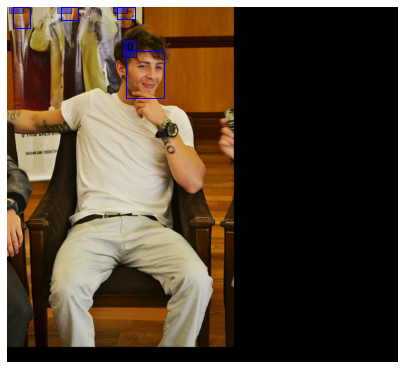

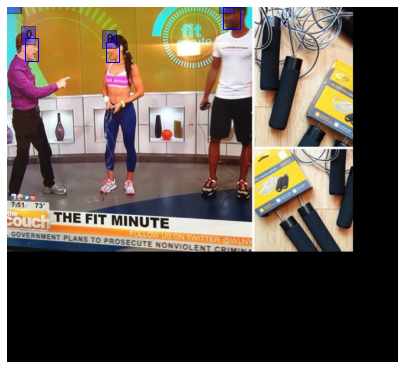

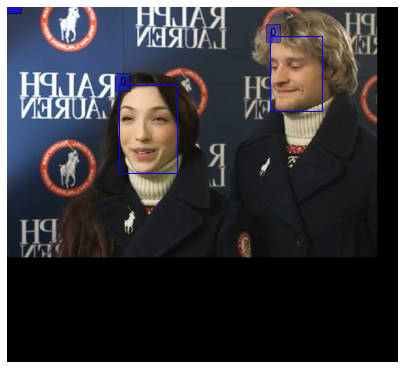

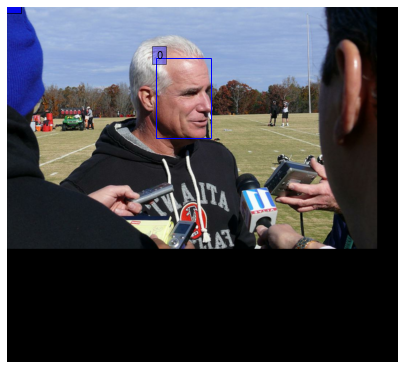

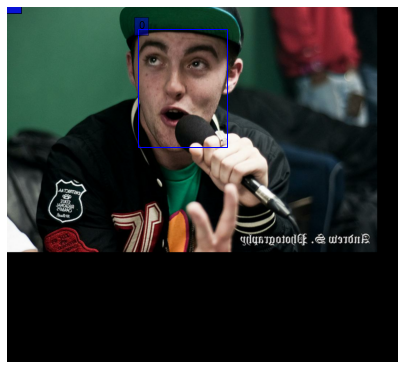

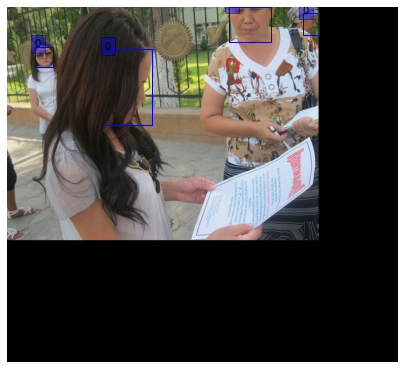

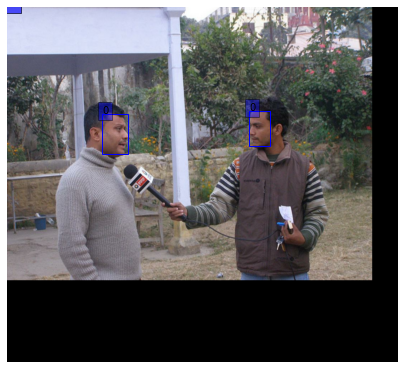

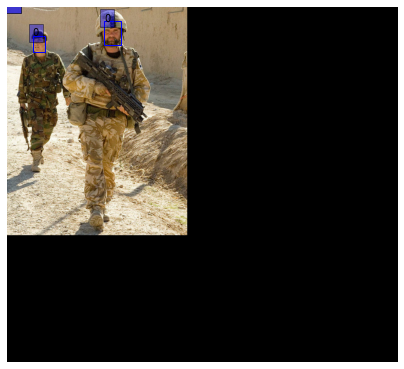

In [109]:
for i in range(8):
    image, bbox, classes = x.numpy()[i], y.numpy()[i], z.numpy()[i]
    visualize_detections2(image,bbox,classes)

In [151]:
image, bbox, class_id = preprocess_data(a)

In [143]:
bbox

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[931.2456 , 673.2932 , 247.18182, 389.55222],
       [360.202  , 577.04315, 454.976  , 261.69495],
       [723.50854, 430.52063,  89.55524, 286.45508]], dtype=float32)>

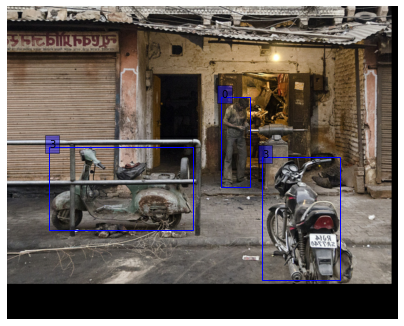

<AxesSubplot:>

In [152]:
visualize_detections2(image.numpy(),bbox.numpy(),class_id.numpy())

In [153]:
image.shape

TensorShape([1024, 1280, 3])

In [110]:
class AnchorBox:
    """Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


In [115]:
class LabelEncoder:
    """Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.

    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.

        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.

        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
